In [ ]:
import os
import torch
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint

import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。

import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import guidedlda

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

import pyvis
import IPython
import random
from itertools import combinations

from getpass import getpass
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain_community.llms import HuggingFaceEndpoint

from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
import accelerate

In [ ]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = 'font/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break


In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./data/Dcard_Travel_Koren.csv')
origin_data.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['boardID', 'commentCount', 'department', 'gender', 'school', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData.head(3)

In [32]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:1200]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2024-05-28 17:07:40,340 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-28 17:07:42,382 - BERTopic - Dimensionality - Completed ✓
2024-05-28 17:07:42,383 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-28 17:07:42,402 - BERTopic - Cluster - Completed ✓
2024-05-28 17:07:42,404 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Team-8-Project/第8組_HW4/dict/dict.txt.big ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uae7a9c0933838549a2b33dd288d68850.cache
Loading model cost 0.481 seconds.
Prefix dict has been built successfully.
2024-05-28 17:07:42,944 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,1134,0_ _吃_韓國_釜山,"[ , 吃, 韓國, 釜山, 行程, 推薦, 買, 首爾, 晚餐, 拍, 韓服, 飯店, 地...","[附近咖啡廳吃早餐首爾智選酒店弘大附近走走飄到狎鷗亭逛逛跟朋友吃晚餐回弘大迎接金主, 行程桃..."
1,1,51,1_ _種_紙片_資訊,"[ , 種, 紙片, 資訊, , , , , , , , , , , , , , , , ,...","[更多資訊, 紙片, 種]"
2,2,15,2_星期六_地址_營業時間_星期一,"[星期六, 地址, 營業時間, 星期一, 開橋, 公休, , 每週六, 星期日, 星期五,...","[星期六地址, 星期六日地址, 星期六去才不會撲空唷營業時間開橋表演每週六]"


In [17]:
zh_topic_model.visualize_topics()

In [ ]:
zh_topic_model.visualize_topics()

In [18]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


In [19]:
zh_topic_model.visualize_distribution(topic_distr[18])

In [20]:
zh_topic_model.get_topic(1)

[('韓國', 0.0985953341458618),
 ('首爾', 0.06653533093388321),
 ('韓服', 0.046355454990548974),
 (' ', 0.029170516934461415),
 ('釜山', 0.028090921142298098),
 ('行程', 0.027099755369188683),
 ('旅遊', 0.02505492305058671),
 ('機場', 0.020528880225145697),
 ('全州', 0.019270606157840545),
 ('畢業', 0.017583739549945073),
 ('一隻', 0.0165015342011545),
 ('公社', 0.01594893630899791),
 ('鞋子', 0.01594893630899791),
 ('韓趣', 0.01594893630899791),
 ('啊啊啊', 0.01594893630899791),
 ('縱遊', 0.01594893630899791),
 ('祭', 0.01594893630899791),
 ('想', 0.015789477909311983),
 ('觀光', 0.015189778371078981),
 ('市區', 0.015189778371078981),
 ('日本', 0.014571002754953202),
 ('拍拍', 0.014571002754953202),
 ('穿', 0.014366651995398744),
 ('逛逛', 0.01384877902929129),
 ('分享', 0.013613122335909113),
 ('學士', 0.013390731798862236),
 ('拍照', 0.013390731798862236),
 ('搭乘', 0.013201227360923601),
 ('雞', 0.013201227360923601),
 ('找', 0.012980493426329256)]

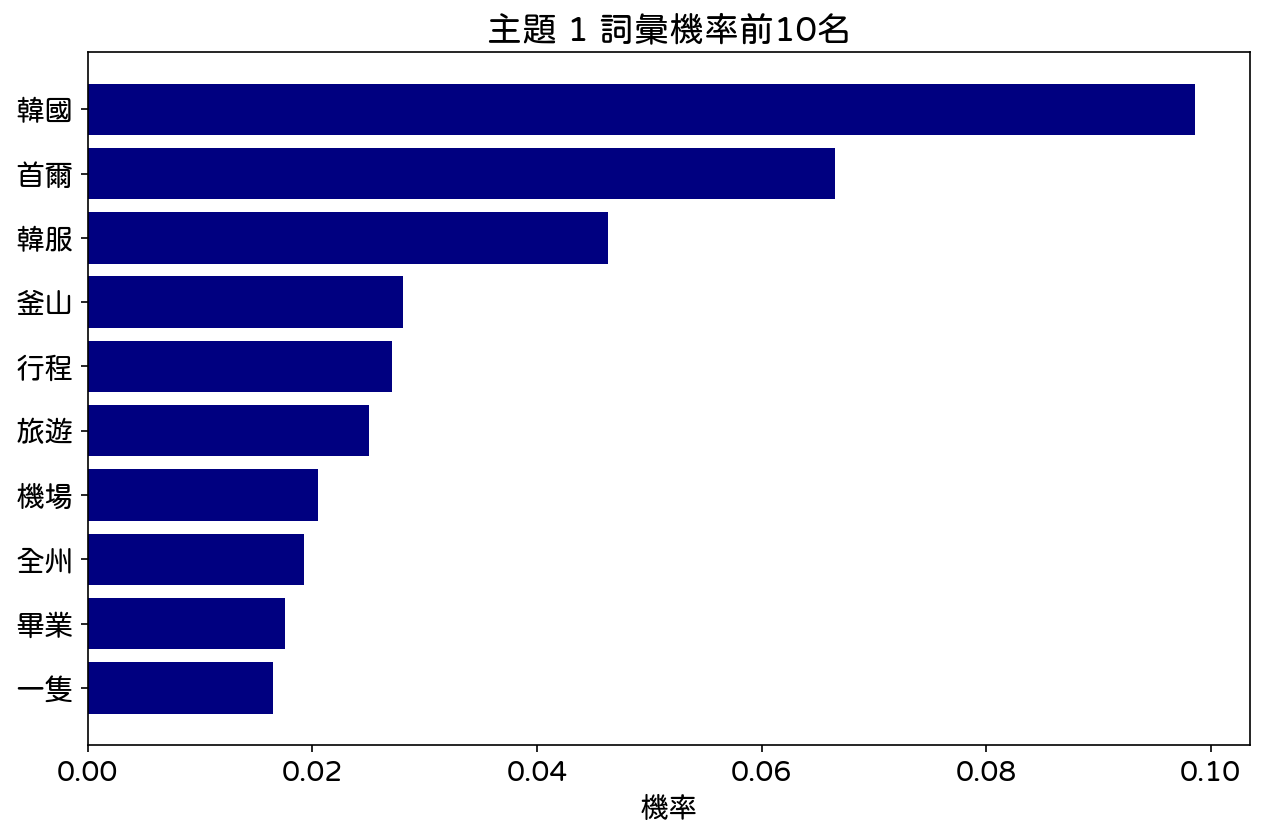

In [21]:
# 視覺化顯示主題-詞彙分佈
topic_n = 1
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()